영화추천시스템

이름 : 박병규

학번 : 20181612

데이터 출처 : https://grouplens.org/datasets/movielens/latest/

### Task 1. (15 점) 데이터 준비하기


Task 1-1. (5 점) 파일을 다운로드 받고 (requests, zipfile 사용), ratings.csv 파일을 읽어서 80%
20% 비율의 train, test 데이터로 나누기

In [509]:
import requests
import zipfile
import pandas as pd
import re
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math
import operator

In [510]:
movie = requests.get('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')

with open ("movie.zip", "wb") as f :
  f.write(movie.content)
zipfile.ZipFile("movie.zip").extractall("./")

In [511]:
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [512]:
## split data into train and test


ratings = ratings.sample(frac=1).reset_index(drop=True)

train_size = int(len(ratings)*0.8)
test_size = len(ratings) - train_size

train = ratings[:train_size]
test = ratings[train_size:]

print(train_size, test_size)

80668 20168


In [513]:
# 영화 아이디 집합
movieId_li = []
aa = ratings.sort_values('movieId')
for i in range(len(ratings)) :
  if int(aa['movieId'].iloc[i]) not in movieId_li :
    movieId_li.append(int(aa['movieId'].iloc[i]))

In [514]:
movieId_li[:20]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Task 1-2. (5 점) movies.csv 파일을 읽고, 장르를 집합으로 변환하기

In [515]:
def str_to_set(s):
    ret = s.split('|')
    genre_set = set(ret)
    return genre_set

In [516]:
movies_data = pd.read_csv('/content/ml-latest-small/movies.csv')
movies_data['genres'] = movies_data['genres'].apply(str_to_set)
movies_data

,movieId,title,genres
0,1,Toy Story (1995),"{Fantasy, Children, Animation, Comedy, Adventure}"
1,2,Jumanji (1995),"{Fantasy, Adventure, Children}"
2,3,Grumpier Old Men (1995),"{Comedy, Romance}"
3,4,Waiting to Exhale (1995),"{Drama, Comedy, Romance}"
4,5,Father of the Bride Part II (1995),{Comedy}
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"{Fantasy, Comedy, Action, Animation}"
9738,193583,No Game No Life: Zero (2017),"{Fantasy, Comedy, Animation}"
9739,193585,Flint (2017),{Drama}
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"{Action, Animation}"


Task 1-3. (5 점) tags.csv 파일을 읽고, tag들을 모두 소문자로 변환 후, 영화별로 tag들을 묶어서
집합으로 변환하기 (예: 122912번 영화(Avengers: Infinity War - Part I)의 tag집합 = {visually
stunning, visually appealing, thor, thanos, sad, robert downey jr., mcu, marvel, guardians of
the galaxy, great villain, emotional, dr. strange, dark, comic book})

In [517]:
t = pd.read_csv('/content/ml-latest-small/tags.csv')
t = t.sort_values('movieId')

# 튜플로 movieId, tag추출
subset = t[['movieId','tag']]
tuples = [tuple(x) for x in subset.to_numpy()]

i = 0
id_list = [] # movidId 들어있는 list
tag_list = [] # tag 들어있는 list
tags = set()

for x,y in tuples :
  if x in id_list:
    tmp.add(y.lower())
  else :
    if i != 0 :
      tag_list.append(tmp)
    id_list.append(x)
    tmp = set()
    tmp.add(y.lower())
    i = i +1

# 마지막 tag 넣어주기
tag_list.append(tmp)

## dataframe으로 만들기
tag_set = pd.DataFrame({'movieId' : id_list,
                        'tags' : tag_list})

tag_set

,movieId,tags
0,1,"{pixar, fun}"
1,2,"{game, robin williams, magic board game, fantasy}"
2,3,"{old, moldy}"
3,5,"{pregnancy, remake}"
4,7,{remake}
...,...,...
1567,183611,"{comedy, rachel mcadams, funny}"
1568,184471,"{video game adaptation, alicia vikander, adven..."
1569,187593,"{ryan reynolds, sarcasm, josh brolin}"
1570,187595,"{emilia clarke, star wars}"


In [518]:
# example
# 예: 122912번 영화(Avengers: Infinity War - Part I 
# tag집합 = {visually stunning, visually appealing, thor, thanos, sad, robert downey jr., 
#              mcu, marvel, guardians of the galaxy, great villain, emotional, dr. strange, dark, comic book})

tag_set[tag_set['movieId']==122912]

,movieId,tags
1522,122912,"{guardians of the galaxy, dark, thanos, visual..."


### Task 2. (25 점) Latent Factor 모델을 이용하여 학습하기


● Task 2-1. (20 점) P, Q 등 파라미터 초기화 후, optimizer 등을 이용해서 학습하기 ○ 기본 5점 ○ (+5 점) bias 추가 ○ (+5 점) regularization 추가 ○ (+5 점) hyper parameter (learning rate, regularization weight 등) 탐색

In [519]:
users = torch.LongTensor(train['userId'].values)
movies = torch.LongTensor(train['movieId'].values)
rating = torch.FloatTensor(train['rating'].values)

users_test = torch.LongTensor(test['userId'].values)
movies_test = torch.LongTensor(test['movieId'].values)
rating_test = torch.FloatTensor(test['rating'].values)

In [520]:
len(movies)

80668

In [521]:
rank = 3

num_users = users.max()+1
num_movies = movies.max()+1

P = torch.randn(num_users, rank, requires_grad = True) # user matrix
Q = torch.randn(num_movies, rank, requires_grad = True) # movies matrix

optimizer = torch.optim.Adam([P, Q], lr= 0.1)

# Regularization weight
lambda_P = 0.0001
lambda_Q = 0.0001
lambda_BU = 0.0001
lambda_BI = 0.0001

# bias
bias_user = torch.randn(num_users, requires_grad = True)
bias_movie = torch.randn(num_movies, requires_grad = True)
mean = (rating.sum()/len(rating)).item()

#bias_user, bias_movie 학습
optimizer = torch.optim.Adam([P, Q, bias_user, bias_movie], lr = 0.1)

#plot
X = []
Y_train = []
Y_test = []

for epoch in range(1001):

  
  hypo = (P[users] * Q[movies]).sum(dim=1) + bias_user[users] + bias_movie[movies] + mean
  rmse = (F.mse_loss(hypo, rating))**0.5
  cost = rmse + lambda_P*(P**2).sum() + lambda_Q*(Q**2).sum() + lambda_BU * (bias_user**2).sum() + lambda_BI * (bias_movie**2).sum()
  
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():

    hypo_train = (P[users] * Q[movies]).sum(dim=1) + bias_user[users] + bias_movie[movies] + mean
    rmse_train = (F.mse_loss(hypo_train, rating))**0.5

    hypo_test = (P[users_test] * Q[movies_test]).sum(dim=1) + bias_user[users_test] + bias_movie[movies_test] + mean
    rmse_test = (F.mse_loss(hypo_test, rating_test))**0.5

    X.append(epoch)
    Y_train.append(rmse_train)
    Y_test.append(rmse_test)

    if epoch % 100 == 0:
      print(f"epoch: {epoch},cost: {cost}, train_rmse: {rmse_train.item()}, test_rmse: {rmse_test.item()}")

epoch: 0,cost: 80.16735076904297, train_rmse: 2.220165491104126, test_rmse: 2.2326297760009766
epoch: 100,cost: 0.8475099205970764, train_rmse: 0.7621699571609497, test_rmse: 0.8520178198814392
epoch: 200,cost: 0.843898594379425, train_rmse: 0.7559587955474854, test_rmse: 0.8481227159500122
epoch: 300,cost: 0.8436477184295654, train_rmse: 0.755294680595398, test_rmse: 0.8474523425102234
epoch: 400,cost: 0.8435727953910828, train_rmse: 0.7552003264427185, test_rmse: 0.8474055528640747
epoch: 500,cost: 0.8435578346252441, train_rmse: 0.7552019357681274, test_rmse: 0.8475549817085266
epoch: 600,cost: 0.8435549139976501, train_rmse: 0.7551981210708618, test_rmse: 0.8475745320320129
epoch: 700,cost: 0.8435565233230591, train_rmse: 0.7552011609077454, test_rmse: 0.8475825190544128
epoch: 800,cost: 0.8435548543930054, train_rmse: 0.7551995515823364, test_rmse: 0.8475865125656128
epoch: 900,cost: 0.8435546159744263, train_rmse: 0.7551931738853455, test_rmse: 0.8475686311721802
epoch: 1000,cost

In [585]:
rank = 10

num_users = users.max()+1
num_movies = movies.max()+1

P = torch.randn(num_users, rank, requires_grad = True) # user matrix
Q = torch.randn(num_movies, rank, requires_grad = True) # movies matrix

optimizer = torch.optim.Adam([P, Q], lr= 0.1)

# Regularization weight
lambda_P = 0.00001
lambda_Q = 0.00001
lambda_BU = 0.00001
lambda_BI = 0.00001

# bias
bias_user = torch.randn(num_users, requires_grad = True)
bias_movie = torch.randn(num_movies, requires_grad = True)
mean = (rating.sum()/len(rating)).item()

#bias_user, bias_movie 학습
optimizer = torch.optim.Adam([P, Q, bias_user, bias_movie], lr = 0.1)

#plot
X = []
Y_train = []
Y_test = []

for epoch in range(1001):


  hypo = (P[users] * Q[movies]).sum(dim=1) + bias_user[users] + bias_movie[movies] + mean
  rmse = (F.mse_loss(hypo, rating))**0.5
  cost = rmse + lambda_P*(P**2).sum() + lambda_Q*(Q**2).sum() + lambda_BU * (bias_user**2).sum() + lambda_BI * (bias_movie**2).sum()
  
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():

    hypo_train = (P[users] * Q[movies]).sum(dim=1) + bias_user[users] + bias_movie[movies] + mean
    rmse_train = (F.mse_loss(hypo_train, rating))**0.5

    hypo_test = (P[users_test] * Q[movies_test]).sum(dim=1) + bias_user[users_test] + bias_movie[movies_test] + mean
    rmse_test = (F.mse_loss(hypo_test, rating_test))**0.5

    X.append(epoch)
    Y_train.append(rmse_train)
    Y_test.append(rmse_test)

    if epoch % 100 == 0:
      print(f"epoch: {epoch},cost: {cost}, train_rmse: {rmse_train.item()}, test_rmse: {rmse_test.item()}")

epoch: 0,cost: 24.88922119140625, train_rmse: 3.032557487487793, test_rmse: 3.1366944313049316
epoch: 100,cost: 0.5276567339897156, train_rmse: 0.45241010189056396, test_rmse: 1.0153858661651611
epoch: 200,cost: 0.5150861144065857, train_rmse: 0.4390605390071869, test_rmse: 1.0376076698303223
epoch: 300,cost: 0.5128546953201294, train_rmse: 0.4363044202327728, test_rmse: 1.0454331636428833
epoch: 400,cost: 0.5114067196846008, train_rmse: 0.434237539768219, test_rmse: 1.0468922853469849
epoch: 500,cost: 0.510793924331665, train_rmse: 0.43333521485328674, test_rmse: 1.0463613271713257
epoch: 600,cost: 0.5104091167449951, train_rmse: 0.4327775835990906, test_rmse: 1.047555685043335
epoch: 700,cost: 0.5100657939910889, train_rmse: 0.43248990178108215, test_rmse: 1.049656867980957
epoch: 800,cost: 0.510047197341919, train_rmse: 0.43250352144241333, test_rmse: 1.0489476919174194
epoch: 900,cost: 0.5099151730537415, train_rmse: 0.4324030578136444, test_rmse: 1.049491047859192
epoch: 1000,cost

● Task 2-2. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)

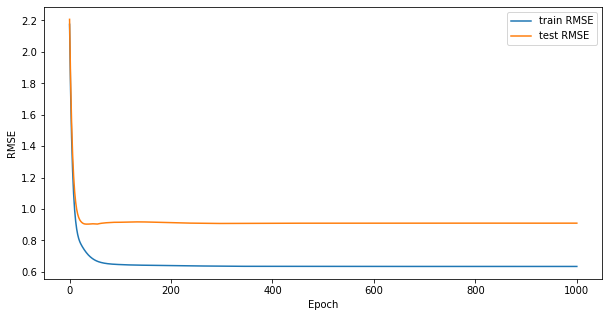

In [523]:
# plt.plot(X,Y)

plt.figure(figsize = (10,5))

plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.plot(X,Y_train, label="train RMSE")
plt.plot(X,Y_test, label = "test RMSE") # overfiting
plt.legend()

plt.show()

### Task 3. (20 점) 514번 User에게 추천하기 (knn search, similarity)

In [524]:
## euclidean distance between a, b

def distance(a,b) :
  s = 0
  for ai,bi in zip(a,b):
    s += (bi-ai)**2
  return s ** 0.5

In [525]:
def nan_to_set(s) :
  if(s == 0):
    return set([])
  else:
    return s

In [526]:
def jaccard_similarity(set1, set2) :
    if len(set1 | set2) == 0 : return 0
    return len(set1 & set2)/len(set1 | set2)

In [527]:
def cos_sim(A,B) :
  return dot(A,B)/(norm(A)*norm(B))

In [528]:
# pearson_similarity
def pearson_similarity(a, b):
    a = a - a.mean() # 평균이 0이 되도록 하는 작업
    b = b - b.mean()
    denom = np.sqrt(np.sum(a ** 2) * np.sum(b ** 2))
    if denom != 0:
        return np.sum(a * b)/denom
    else:
        return 0

In [529]:
# data 합치기
total_data1 = pd.merge(ratings[['userId','movieId','rating']],movies_data, on='movieId', how = 'left')
total_data = pd.merge(total_data1, tag_set, on = 'movieId', how = 'left')
total_data

,userId,movieId,rating,title,genres,tags
0,217,2344,3.0,Runaway Train (1985),"{Drama, Adventure, Action, Thriller}",NaN
1,187,50,4.5,"Usual Suspects, The (1995)","{Crime, Thriller, Mystery}","{suspense, mindfuck, thriller, heist, tricky, ..."
2,1,3793,5.0,X-Men (2000),"{Sci-Fi, Adventure, Action}","{superhero, comic book, action, marvel, hugh j..."
3,380,2791,4.0,Airplane! (1980),{Comedy},"{spoof, aviation}"
4,91,3421,3.5,Animal House (1978),{Comedy},"{toga, college}"
...,...,...,...,...,...,...
100831,570,653,3.0,Dragonheart (1996),"{Fantasy, Adventure, Action}",NaN
100832,288,2000,3.0,Lethal Weapon (1987),"{Crime, Comedy, Action, Drama}",NaN
100833,261,30810,1.0,"Life Aquatic with Steve Zissou, The (2004)","{Fantasy, Comedy, Adventure}","{visually appealing, trippy, whimsical, off-be..."
100834,212,112552,4.5,Whiplash (2014),{Drama},"{intense, inspiring, inspirational, jazz, susp..."


In [530]:
matrix = total_data.pivot_table( index = 'userId', columns = 'title', values = 'rating')
matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


● Task 3-1. (10 점) 514번 user의 예상 별점이 가장 높은 영화 20개를 찾아서 id 및 영화 이름
출력하기

In [531]:
matrix2 =  total_data.pivot_table( index = 'userId', columns = 'title', values = 'rating')
# 결측치 각 영화의 평균 별점으로 채워줌
for i in matrix2.columns:
  mean = matrix2[i].mean()
  matrix2[i]=matrix2[i].fillna(mean)
matrix2.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,2.0,3.166667,4.5,4.0,3.375,1.25,3.678571,2.666667,3.527778,3.5,2.705882,3.25,2.5,3.074468,3.431818,2.5,3.5,2.777778,4.5,2.75,4.0,4.0,3.75,4.0,4.149123,5.0,4.5,5.0,3.0,3.625,...,3.375,4.0,3.0,3.5,3.0,4.5,5.0,3.75,4.0,4.0,4.107143,3.966667,3.0,4.0,1.0,2.0,3.710526,2.5,4.0,0.5,3.877358,2.0,3.5,2.75,3.509259,2.5,2.5,2.5,3.890625,4.0,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,2.0,3.166667,4.5,4.0,3.375,1.25,3.678571,2.666667,3.527778,3.5,2.705882,3.25,2.5,3.074468,3.431818,2.5,3.5,2.777778,4.5,2.75,4.0,4.0,3.75,4.0,4.149123,5.0,4.5,5.0,3.0,3.625,...,3.375,4.0,3.0,3.5,3.0,4.5,5.0,3.75,4.0,4.0,4.107143,3.966667,3.0,4.0,1.0,2.0,3.710526,2.5,4.0,0.5,3.000000,2.0,3.5,2.75,3.509259,2.5,2.5,2.5,3.890625,4.0,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,2.0,3.166667,4.5,4.0,3.375,1.25,3.678571,2.666667,3.527778,3.5,2.705882,3.25,2.5,3.074468,3.431818,2.5,3.5,2.777778,4.5,2.75,4.0,4.0,3.75,4.0,4.149123,5.0,4.5,5.0,3.0,3.625,...,3.375,4.0,3.0,3.5,3.0,4.5,5.0,3.75,4.0,4.0,4.107143,3.966667,3.0,4.0,1.0,2.0,3.710526,2.5,4.0,0.5,3.877358,2.0,3.5,2.75,3.509259,2.5,2.5,2.5,3.890625,4.0,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,2.0,3.166667,4.5,4.0,3.375,1.25,3.678571,2.666667,3.527778,3.5,2.705882,3.25,2.5,3.074468,3.431818,2.5,3.5,2.777778,4.5,2.75,4.0,4.0,3.75,4.0,5.000000,5.0,4.5,5.0,3.0,3.625,...,3.375,4.0,3.0,3.5,3.0,4.5,5.0,3.75,4.0,4.0,4.107143,3.966667,3.0,4.0,1.0,2.0,3.710526,2.5,4.0,0.5,3.877358,2.0,3.5,2.75,3.509259,2.5,2.5,2.5,3.890625,4.0,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,2.0,3.166667,4

In [532]:
def recomend(name, dataframe):
    
  matrix3 = total_data.pivot_table( index = 'userId', columns = 'title', values = 'rating')
  movies = []
  for i in matrix3.loc[name,:].index:
    if math.isnan(matrix3.loc[name,i]) == False:
      movies.append(i)

  df1 = pd.DataFrame(matrix3.loc[name,movies] ).T
  other_df=dataframe.loc[:,movies].drop(name, axis=0)

  
  df_list = list(df1.index)
  sim_dict={}
    
  # user - user
  for user in other_df.index:
    sm= [m for m in df1.columns if math.isnan(other_df.loc[user,m])==False]
    sim_dict[user] = cos_sim(df1.loc[name,sm],other_df.loc[user,sm])

  sim_mat=sorted(sim_dict.items() ,key=operator.itemgetter(1), reverse=True)  
    
  recommend_list = list(set(dataframe.columns) - set(df1.columns))
  others_k = [i[0] for i in sim_mat]
  recommender = dict()
  for movie in recommend_list:
    rating=[]
    sim=[]
    for person in others_k:
      if math.isnan(dataframe.loc[person,movie])==False:
        rating.append(dataframe.loc[person,movie])
        sim.append(sim_dict[person])

    if len(sim) == 1 | len(rating) ==1 : 
      pred = sim[0] * rating[0]
    else :
      pred=((sim[0]*rating[0])+(sim[1]*rating[1]))/(sim[0]+sim[1])

    recommender[movie]= pred

  return sorted(recommender.items(), key=operator.itemgetter(1), reverse=True)

ret = recomend(514, matrix2)

In [533]:
ret[:20]

[('Knock Off (1998)', 5.0),
 ("Won't You Be My Neighbor? (2018)", 5.0),
 ('Holy Motors (2012)', 5.0),
 ('Tokyo Tribe (2014)', 5.0),
 ('Dylan Moran: Monster (2004)', 5.0),
 ('Rain (2001)', 5.0),
 ('Jump In! (2007)', 5.0),
 ('Thousand Clowns, A (1965)', 5.0),
 ("Summer's Tale, A (Conte d'été) (1996)", 5.0),
 ('Seve (2014)', 5.0),
 ('Tales of Manhattan (1942)', 5.0),
 ('Lesson Faust (1994)', 5.0),
 ('Lumberjack Man (2015)', 5.0),
 ('My Sassy Girl (Yeopgijeogin geunyeo) (2001)', 5.0),
 ('Bloodsucking Bastards (2015)', 5.0),
 ('The Fox and the Hound 2 (2006)', 5.0),
 ('Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)', 5.0),
 ('Colourful (Karafuru) (2010)', 5.0),
 ('Slumber Party Massacre II (1987)', 5.0),
 ('Three from Prostokvashino (1978)', 5.0)]

In [534]:
## 답
for i in range(20) :
  print('movieId: ', movies_data[movies_data['title'] == ret[i][0]]['movieId'].values, 'title: ', movies_data[movies_data['title'] == ret[i][0]]['title'].values)

movieId:  [2196] title:  ['Knock Off (1998)']
movieId:  [187717] title:  ["Won't You Be My Neighbor? (2018)"]
movieId:  [96832] title:  ['Holy Motors (2012)']
movieId:  [138632] title:  ['Tokyo Tribe (2014)']
movieId:  [92494] title:  ['Dylan Moran: Monster (2004)']
movieId:  [5328] title:  ['Rain (2001)']
movieId:  [143031] title:  ['Jump In! (2007)']
movieId:  [26147] title:  ['Thousand Clowns, A (1965)']
movieId:  [26928] title:  ["Summer's Tale, A (Conte d'été) (1996)"]
movieId:  [132333] title:  ['Seve (2014)']
movieId:  [25887] title:  ['Tales of Manhattan (1942)']
movieId:  [1151] title:  ['Lesson Faust (1994)']
movieId:  [149350] title:  ['Lumberjack Man (2015)']
movieId:  [27523] title:  ['My Sassy Girl (Yeopgijeogin geunyeo) (2001)']
movieId:  [141928] title:  ['Bloodsucking Bastards (2015)']
movieId:  [126921] title:  ['The Fox and the Hound 2 (2006)']
movieId:  [1349] title:  ['Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)']
movieId:  [112512] title: 

● Task 3-2. (10 점) 장르 및 tag를 기준으로, 514번 user가 5점을 준 영화들을 찾고, 각각의 영화와
가장 유사한 영화를 5개씩 찾아서 id, 영화 이름, 유사도 점수 출력하기

In [535]:
# 514가 5점 준 영화 출력
user_514 = total_data[(total_data['userId']==514) & (total_data['rating'] == 5)]
user_514

,userId,movieId,rating,title,genres,tags
949,514,1387,5.0,Jaws (1975),"{Horror, Action}",{shark}
13929,514,260,5.0,Star Wars: Episode IV - A New Hope (1977),"{Sci-Fi, Adventure, Action}","{space adventure, nerd, great soundtrack, spac..."
15873,514,80463,5.0,"Social Network, The (2010)",{Drama},"{loneliness, good dialogue, witty}"
16564,514,2398,5.0,Miracle on 34th Street (1947),"{Drama, Comedy}",NaN
18232,514,593,5.0,"Silence of the Lambs, The (1991)","{Crime, Horror, Thriller}","{psychology, drama, hannibal lector, gothic, s..."
29647,514,52435,5.0,How the Grinch Stole Christmas! (1966),"{Fantasy, Comedy, Musical, Animation}",NaN
30817,514,1197,5.0,"Princess Bride, The (1987)","{Fantasy, Romance, Action, Comedy, Adventure}","{six-fingered man, inigo montoya}"
31392,514,26133,5.0,"Charlie Brown Christmas, A (1965)","{Comedy, Children, Animation}",NaN
32645,514,3471,5.0,Close Encounters of the Third Kind (1977),"{Drama, Adventure, Sci-Fi}",NaN
45107,514,1270,5.0,Back to the Future (1985),"{Sci-Fi, Comedy, Adventure}",{time travel}


In [536]:
# 결측치 처리
user_514['tags'] = user_514['tags'].fillna(0)
user_514['tags'] = user_514['tags'].apply(nan_to_set)
user_514

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,userId,movieId,rating,title,genres,tags
949,514,1387,5.0,Jaws (1975),"{Horror, Action}",{shark}
13929,514,260,5.0,Star Wars: Episode IV - A New Hope (1977),"{Sci-Fi, Adventure, Action}","{space adventure, nerd, great soundtrack, spac..."
15873,514,80463,5.0,"Social Network, The (2010)",{Drama},"{loneliness, good dialogue, witty}"
16564,514,2398,5.0,Miracle on 34th Street (1947),"{Drama, Comedy}",{}
18232,514,593,5.0,"Silence of the Lambs, The (1991)","{Crime, Horror, Thriller}","{psychology, drama, hannibal lector, gothic, s..."
29647,514,52435,5.0,How the Grinch Stole Christmas! (1966),"{Fantasy, Comedy, Musical, Animation}",{}
30817,514,1197,5.0,"Princess Bride, The (1987)","{Fantasy, Romance, Action, Comedy, Adventure}","{six-fingered man, inigo montoya}"
31392,514,26133,5.0,"Charlie Brown Christmas, A (1965)","{Comedy, Children, Animation}",{}
32645,514,3471,5.0,Close Encounters of the Third Kind (1977),"{Drama, Adventure, Sci-Fi}",{}
45107,514,1270,5.0,Back to the Future (1985),"{Sci-Fi, Comedy, Adventure}",{time travel}


In [537]:
keywords = pd.merge(movies_data, tag_set, on ='movieId', how = 'outer')
keywords['tags'] = keywords['tags'].fillna(0)
keywords['tags'] = keywords['tags'].apply(nan_to_set)
keywords['genres'] = keywords['genres'].fillna(0)
keywords['genres'] = keywords['genres'].apply(nan_to_set)
keywords.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),"{Fantasy, Children, Animation, Comedy, Adventure}","{pixar, fun}"
1,2,Jumanji (1995),"{Fantasy, Adventure, Children}","{game, robin williams, magic board game, fantasy}"
2,3,Grumpier Old Men (1995),"{Comedy, Romance}","{old, moldy}"
3,4,Waiting to Exhale (1995),"{Drama, Comedy, Romance}",{}
4,5,Father of the Bride Part II (1995),{Comedy},"{pregnancy, remake}"


In [538]:
def find_sim_movie(title, matrix, n = 5, alpha = 0.5) :
  meta = keywords.loc[keywords['title'] == title].iloc[0]
  tags_gen = meta['genres'] | meta['tags']
  
  ret = []

  for t in matrix.columns :
    if t == title :
      continue

    meta2 = keywords.loc[keywords['title'] == t].iloc[0]
    tags_gen2 = meta2['genres'] | meta2['tags']

    pearson = pearson_similarity(matrix[t],matrix[title])
    jaccard = jaccard_similarity(tags_gen2, tags_gen)

    score = alpha * pearson + (1-alpha) * jaccard
    ret.append((meta2['movieId'], t, score) )
        
  ret.sort(key = lambda r : -r[2])
  
  return ret[:n]

In [539]:
for i in range(0, len(user_514)) :
  ret = find_sim_movie(user_514['title'].iloc[i], matrix)
  print("제목: ", user_514['title'].iloc[i])
  for j in range(0,len(ret)) :
    print("id: ", ret[j][0], " title: ", ret[j][1], "similar: ", ret[j][2])

제목:  Jaws (1975)
id:  1389  title:  Jaws 3-D (1983) similar:  0.5195342073724587
id:  3563  title:  Crow: Salvation, The (2000) similar:  0.3738228792587921
id:  5833  title:  Dog Soldiers (2002) similar:  0.35683842670594634
id:  59129  title:  Outpost (2008) similar:  0.35380057632862016
id:  62299  title:  Alone in the Dark II (2008) similar:  0.3333333333333333
제목:  Star Wars: Episode IV - A New Hope (1977)
id:  1196  title:  Star Wars: Episode V - The Empire Strikes Back (1980) similar:  0.41402824638816405
id:  1210  title:  Star Wars: Episode VI - Return of the Jedi (1983) similar:  0.40937194898224905
id:  2571  title:  Matrix, The (1999) similar:  0.16903332408979158
id:  480  title:  Jurassic Park (1993) similar:  0.16831579674290958
id:  60514  title:  Journey to the Center of the Earth (2008) similar:  0.16420797622986
제목:  Social Network, The (2010)
id:  66371  title:  Departures (Okuribito) (2008) similar:  0.30780537295982147
id:  72641  title:  Blind Side, The  (2009) s

### Task 4. (15 점) 영화 클러스터링하기 (k-means clustering)

● Task 4-1. (5 점) cosine similarity를 기준으로 영화 벡터 (P혹은 Q)에서 k-means clustering
구하기 (k=1, ..., 40 까지 바꿔가면서 cost 값을 계산)

In [540]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
import torch
import torch.nn as nn

In [541]:
# movidID있는 영화만 추출
a = Q.detach().numpy()
a
inmo = [] # id 있는 영화
for i in movieId_li :
  inmo.append(a[i-1])
len(inmo)


9724

In [542]:
def var(a,b) :
  sum = 0;
  for i in range(len(a)) :
    sum = sum + (a[i]-b[i])**2
  return sum

In [571]:
def kmeans(points, k, max_iters = 5) :

  # cost 함수 분산
  # 비용의 감소가 급격히 줄어드는 지점 선택 -> 변곡점
  # 엘보우 포인트

  """
      return labels, cluster_centers
      1. cluster_centers를 랜덤하게 생성한다.
      2. 각각의 점마다 어떤 cluster center와 가장 가까운지 계산, 할당 -> labels 계산
      3. 새로운 labels을 이용해서, 새로운 cluster center 새로 계산
      4. 2~3번 반복하다가... 더이상 업데이트가 없으면 종료

  """
  # 1. cluster_centers를 랜덤하게 생성한다. forgy: 있는 점 중에서 랜덤하게 k개를 골라서 초기 cluster center로 설정
  rad = random.randint(0,len(points))
  cluster_centers = points[np.random.choice(rad, k, replace = False)]



  for iter in range(max_iters)  :
    # 2. 각각의 점마다 어떤 cluster center와 가장 가까운지 계산 및 할당 (a.k.a. labels 계산)
    labels = []
    for p in points :
      # p = points[i-1]
      # pl = list()
      # pl.append(float(p[0]))
      # pl.append(float(p[1]))
      # pl.append(float(p[2]))
      min_dist = np.inf
      min_cid = -1
      for cid, c in enumerate(cluster_centers) :
        # cl = list()
        # cl.append(float(c[0]))
        # cl.append(float(c[1]))
        # cl.append(float(c[2]))
        dist = 1-cos_sim(p, c)  

        if dist < min_dist :
          min_dist = dist
          min_cid = cid
      labels.append(min_cid)

    labels = np.array(labels)


    new_cluster_centers = np.zeros_like(cluster_centers)

    count = [0] * k # count = np.zeros(k)

    # 같은 클러스터에 속한 점들을 평균을 내야한다.
    for l, p in zip(labels, points) :
      new_cluster_centers[l] += p
      count[l] += 1

    for i in range(k) :
      new_cluster_centers[i] /= count[i]

    #print("iteration #", iter)

    if np.array_equal(cluster_centers, new_cluster_centers) :
      break
    else :
      cluster_centers = new_cluster_centers
  
  # J is sum of distance
  cost = 0
  for p in points :
    min_cost = 100
    for t in range(k) :
      if distance(p, cluster_centers[t]) < min_cost :
        min_cost = distance(p, cluster_centers[t])
    cost = cost + min_cost
  
  return labels, cluster_centers, cost

In [546]:
k_cost = []
for i in range(1,41) :
  labels, cluster_centers, cost = kmeans(np.array(inmo), i, max_iters = 10)
  k_cost.append([i, cost])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


● Task 4-2. (5 점) Task 4-1에서 구한 결과를 matplotlib를 활용하여 그래프로 그린 후 가장 적절해
보이는 k값 선택하기

In [562]:
x = []
y = []
for i in range(40) :
  x.append(i)
  y.append(k_cost[i][1])


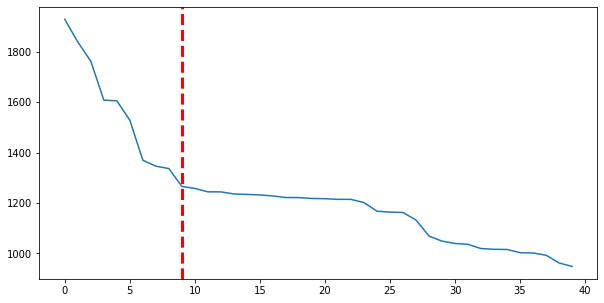

In [564]:
plt.figure(figsize = (10,5))

plt.plot(x,y)
plt.axvline(x= 9, color='r', linestyle='--', linewidth=3)
plt.show()

In [572]:
## k = 9일 경우
labels, cluster_centers, cost = kmeans(np.array(inmo), 9, max_iters = 5)

print('labels:',labels)
print('centers', cluster_centers)
print('cost', cost)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  


labels: [0 5 7 ... 0 1 2]
centers [[-0.01481952 -0.05456667 -0.02748563]
 [ 0.02452781 -0.0746939   0.05154361]
 [ 0.03736869  0.02897563 -0.06504353]
 [ 0.06079077  0.1462408   0.00690058]
 [-0.15948962  0.112496   -0.16778013]
 [-0.13314554  0.16031866  0.2509136 ]
 [ 0.27458325 -0.02286107 -0.00671846]
 [ 0.21238434  0.10223672  0.28414053]
 [-0.2429326  -0.08076831  0.06278012]]
cost 1430.7310700380267


● Task 4-3. (5 점) 122912번 영화(Avengers: Infinity War - Part I)와 같은 cluster에 속한 다른 영화
중 cosine similarity가 가장 높은 영화 20개를 찾아서 id, 영화 이름, 유사도 점수 출력하기

In [565]:
## sklearn의 kmeans을 사용해보자
from sklearn.cluster import KMeans

cost = []
for i in range(1,41):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(inmo)

  cost.append(kmeans.inertia_)

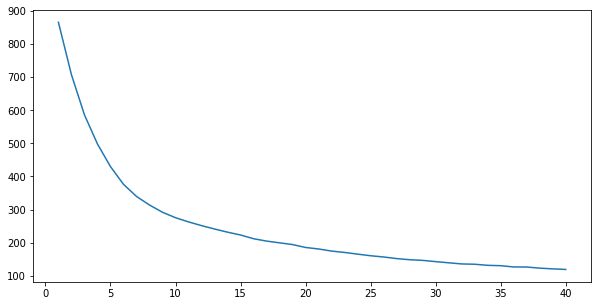

In [568]:
plt.figure(figsize = (10,5))

x = [x for x in range(1,41)]
plt.plot(x,cost)
plt.show()

In [567]:
## 122912번 영화가 어디에 속해 있는지 찾기
pos = movieId_li.index(122912)

# label
target_label = kmeans.labels_[pos]

# 같은 라벨인것들끼리 코사인 유사도 비교
same_label = []
for i in range(len(inmo)) :
  if (kmeans.labels_[i] == target_label) and (i != pos):
    same_label.append(inmo[i])

# same_label 중에서 높은 코사인 유사도 영화 20개
Avengers_friend = []
target = inmo[pos]
cs = 0
for i in range(len(same_label)) :
  cs = cos_sim(target.tolist(), same_label[i].tolist())
  Avengers_friend.append([i+1, cs]) # id는 1부터 시작이니까 i+1

Avengers_friend.sort(key = lambda x:x[1], reverse = True)
Avengers_friend[0:20]


[[3338, 0.9997117004176764],
 [1635, 0.9995717480934783],
 [4463, 0.9993162691361894],
 [1014, 0.9984997094487373],
 [1251, 0.9984561507550402],
 [3489, 0.9982499876593541],
 [4070, 0.9980821556513637],
 [5983, 0.9977782573646061],
 [5893, 0.9974045800137807],
 [4903, 0.99732145801279],
 [3521, 0.9971776781605335],
 [5953, 0.9969071510612161],
 [1950, 0.9964131913288957],
 [426, 0.9956283410543273],
 [2400, 0.9953159395437811],
 [4020, 0.9947405167945058],
 [2031, 0.9947085506629397],
 [4722, 0.994295169890158],
 [6127, 0.9938359800576432],
 [1749, 0.993739964292407]]

In [569]:
for i in range(20) :
  z = Avengers_friend[i][0]
  print('ID: ', movieId_li[z], 'Title: ', movies_data[movies_data['movieId'] == movieId_li[z]]['title'].iloc[0], ' similarity: ', Avengers_friend[i][1])
  print()

ID:  4527 Title:  Night in the Life of Jimmy Reardon, A (1988)  similarity:  0.9997117004176764

ID:  2182 Title:  Wrong Man, The (1956)  similarity:  0.9995717480934783

ID:  6597 Title:  Princess Blade, The (Shura Yukihime) (2001)  similarity:  0.9993162691361894

ID:  1326 Title:  Amityville II: The Possession (1982)  similarity:  0.9984997094487373

ID:  1663 Title:  Stripes (1981)  similarity:  0.9984561507550402

ID:  4775 Title:  Glitter (2001)  similarity:  0.9982499876593541

ID:  5816 Title:  Harry Potter and the Chamber of Secrets (2002)  similarity:  0.9980821556513637

ID:  37477 Title:  Man, The (2005)  similarity:  0.9977782573646061

ID:  33672 Title:  Lords of Dogtown (2005)  similarity:  0.9974045800137807

ID:  7366 Title:  Jersey Girl (2004)  similarity:  0.99732145801279

ID:  4818 Title:  Extreme Days (2001)  similarity:  0.9971776781605335

ID:  35347 Title:  Animal Farm (1954)  similarity:  0.9969071510612161

ID:  2586 Title:  Goodbye Lover (1999)  similarity: 

### Task 5. (25 점) 차원 축소 및 시각화 (PCA)

● Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

In [586]:
aaa = [Q[i-1].tolist() for i in movieId_li]
aaa = torch.FloatTensor(aaa)
aaa

tensor([[-6.0902e-24, -1.0435e-23, -2.6178e-23,  ...,  5.1071e-25,
          3.1251e-24, -2.0036e-23],
        [-1.3714e-01, -2.5002e-01,  2.9652e-01,  ...,  3.0900e-02,
         -1.9596e-01, -3.1915e-02],
        [-5.0226e-02,  1.0672e-01,  2.4118e-01,  ..., -1.8107e-01,
          1.0789e-01, -5.5521e-02],
        ...,
        [-3.5386e-24, -1.0817e-24, -2.5529e-24,  ..., -6.9598e-24,
         -2.9422e-24,  4.3357e-25],
        [-5.7733e-25, -5.3122e-24,  1.6241e-23,  ...,  6.2354e-25,
          1.1297e-23, -4.6912e-24],
        [ 4.8661e-24, -9.7409e-24,  3.5769e-24,  ...,  3.3332e-24,
         -4.7380e-24,  8.0770e-24]])

In [587]:
Z = torch.cat([P, aaa]) #matrix 곱셈
Z = Z.detach()
Z

tensor([[ 4.0162e-24,  2.2434e-24, -2.2559e-24,  ...,  1.3096e-24,
          6.9001e-25, -1.0567e-23],
        [-8.2238e-02,  4.2144e-02, -2.7307e-01,  ..., -6.1105e-02,
          9.3336e-01,  7.6676e-01],
        [ 1.1866e+00,  5.7509e-01,  2.9814e-01,  ..., -3.6287e-02,
          1.6954e-01,  2.7862e-01],
        ...,
        [-3.5386e-24, -1.0817e-24, -2.5529e-24,  ..., -6.9598e-24,
         -2.9422e-24,  4.3357e-25],
        [-5.7733e-25, -5.3122e-24,  1.6241e-23,  ...,  6.2354e-25,
          1.1297e-23, -4.6912e-24],
        [ 4.8661e-24, -9.7409e-24,  3.5769e-24,  ...,  3.3332e-24,
         -4.7380e-24,  8.0770e-24]])

● Task 5-2. (5 점) Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기

In [588]:
def findPC(z):
  dim = z.shape[1]
  w = torch.randn(dim)
  # w 크기가 1이 아니다:
  w = w/(w ** 2 ).sum() ** 0.5 # 길이
    
  lr = 0.1

  for epoch in range(1001) : 
    w.requires_grad_(True)
    # variance 
    variance = ((z @ w.view(-1, 1))**2).mean()

    variance.backward(retain_graph=True)

    with torch.no_grad():
      w = w + lr * w.grad
      w = w/(w ** 2 ).sum() ** 0.5

      # print(f"epoch: {epoch}, w: {w}, var: {variance}")

  return w, variance.item()

In [589]:
def PCA(z,n) :
  W = []
  V = []

  for _ in range(n) :
    w,v = findPC(z)
    W.append(w)
    V.append(v)
    z = z - (z@w.view(-1,1)) *2

  return W, ValueError

In [590]:
def transform(Z,W) :
  return Z @ torch.stack(W).T

In [591]:
W, V = PCA(Z, 4)
Zt = transform(Z,W)

In [ ]:
# w, v = findPC(Z)
# zz = Z.detach().numpy()

In [ ]:
# plt.axis('equal')
# plt.scatter(zz[:,0], zz[:,1])
# plt.plot([0, W[0][0]], [0, W[0][1]], c = 'red') # PC1
# plt.plot([0, W[1][0]], [0, W[1][1]], c = 'yellow') # PC2
# plt.show()

● Task 5-3. (15 점) matplotlib을 활용하여 Zp의 scatter plot 그리기

○ Task 5-3-1. (5 점) P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기

○ Task 5-3-2. (5 점) Task 3-1의 결과 점들을 다른 색으로 그려 강조하기

○ Task 5-3-3. (5 점) Task 4-2의 k값으로 구한 cluster들을 각기 다른 색으로 그리기

In [595]:
# P, Q
# P -> user
# aaa -> Q압축
print(len(P), len(aaa))

611 9724


In [593]:
# 3-1 데이터
movie_514 = []
for i in user_514['movieId'] :
  movie_514.append(movieId_li.index(i))

In [ ]:
# 4-2 데이터 
# 'labels:',labels
# 'centers', cluster_centers
# 'cost', cost

In [613]:
cluster_centers.tolist()
centers = []
for i in range(len(cluster_centers)) :
  centers.append([cluster_centers[i][0],cluster_centers[i][1]])
centers

[[-0.014819518, -0.054566674],
 [0.02452781, -0.074693896],
 [0.03736869, 0.028975632],
 [0.06079077, 0.1462408],
 [-0.15948962, 0.112496],
 [-0.13314554, 0.16031866],
 [0.27458325, -0.022861069],
 [0.21238434, 0.10223672],
 [-0.2429326, -0.08076831]]

In [616]:
c_x = []
c_y = []
for i in range(len(centers)) :
  c_x.append(centers[i][0])
  c_y.append(centers[i][1])


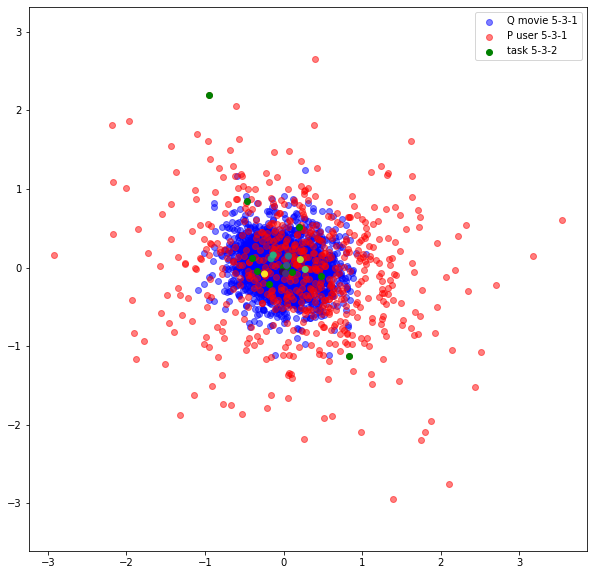

In [624]:
plt.figure(figsize = (10,10))

plt.scatter(Zt[len(P):, 0], Zt[len(P):,1], c = 'blue',alpha = 0.5, label = 'Q movie 5-3-1')
plt.scatter(Zt[:len(P), 0], Zt[:len(P),1], c= 'red', alpha = 0.5, label = 'P user 5-3-1')

plt.scatter(Zt[movie_514, 0], Zt[movie_514,1], c = 'green', label = 'task 5-3-2')

plt.scatter(c_x, c_y, c = [t for t in range(9)])

plt.axis("equal")
plt.legend()
plt.show()
